In [355]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import interpolate
from gatspy.periodic import LombScargleMultibandFast
from scipy import interpolate

In [22]:
"""
!wget https://zenodo.org/record/2539456/files/plasticc_train_lightcurves.csv.gz
!wget https://zenodo.org/record/2539456/files/plasticc_train_metadata.csv.gz
!gzip -d plasticc_train_lightcurves.csv.gz
!gzip -d plasticc_train_metadata.csv.gz
!mv plasticc_train_lightcurves.csv ../Data
!mv plasticc_train_metadata.csv ../Data
"""

'\n!wget https://zenodo.org/record/2539456/files/plasticc_train_lightcurves.csv.gz\n!wget https://zenodo.org/record/2539456/files/plasticc_train_metadata.csv.gz\n!gzip -d plasticc_train_lightcurves.csv.gz\n!gzip -d plasticc_train_metadata.csv.gz\n!mv plasticc_train_lightcurves.csv ../Data\n!mv plasticc_train_metadata.csv ../Data\n'

In [422]:
DATA_DIR = "../Data/"

In [423]:
class LightCurve():
    _pbnames = ['u','g','r','i','z','y']
    _cad_num = {"low":0, "high":1}
    _targets = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    
    def __init__(self, data_file="plasticc_train_lightcurves.csv", target_file='plasticc_train_metadata.csv', cadence="low"):
        raw_data = pd.read_csv(os.path.join(DATA_DIR, data_file))
        target_data = pd.read_csv(os.path.join(DATA_DIR, target_file))
     
        self.cadence = cadence
        self.data_cadence = target_data[target_data["ddf_bool"]==self._cad_num[cadence]]
        self.targets, self.objects = self.data_cadence['target'].values, self.data_cadence['object_id'].values
        
        self.light_curves = raw_data[raw_data["detected_bool"]==self._cad_num[cadence]]
        self.ids = {_id: self.objects[_id] for _id in np.arange(len(self.objects)) }
    
    def get_length(self):
        return len(self.ids)
    
    def show_phase_lightcurve(self, _id, band="all"):
        object_id = self.ids[_id]
        data = self.light_curves[self.light_curves.object_id==object_id]
        
        if band != "all":
                index_band = self._pbnames.index(band)
                lc_mjd = data[data.passband==index_band].mjd.values
                lc_flux = data[data.passband==index_band].flux.values
                lc_flux_err = data[data.passband==index_band].flux_err.values
                lc_passband = data[data.passband==index_band].passband.values
                
                model = LombScargleMultibandFast(fit_period=True)
                t_min = max(np.median(np.diff(sorted(lc_mjd))), 0.1)
                t_max = min(1000., (lc_mjd.max() - lc_mjd.min())/2.)
                
                model.optimizer.set(period_range=(t_min, t_max), first_pass_coverage=5)
                model.fit(lc_mjd, lc_flux, dy=lc_flux_err, filts=lc_passband)
                period = model.best_period

                phase = (lc_mjd /period) % 1
                x = phase
                y = lc_flux
                
                params = np.polyfit(x, y, 5)
                y = self.aproximation_func(x, *params)
                f = interpolate.interp1d(x, y, kind='cubic', fill_value="extrapolate")

                xnew = np.arange(0, 1, 0.01)
                ynew = f(xnew)   # use interpolation function returned by `interp1d`
                plt.plot(x, y, 'o', xnew, ynew)
                plt.show()
                return
        return
    
    def aproximation_func(self, x, *opt):
        n = len(opt)
        y = np.zeros((n, len(x)))
        for k in range(n):
            y[k] = opt[n-k-1]*x**k
        return np.sum(y, axis=0)
    
    def show_lightcurves_by_id(self, _id, band="all", phase=False):
        object_id = self.ids[_id]
        curves = self.light_curves[self.light_curves['object_id']==object_id]
        
        if band != "all":
            index_band = self._pbnames.index(band)
            curve_in_band = curves[curves['passband']==index_band]
            curve_x = curve_in_band['mjd'].values
            curve_y = curve_in_band['flux'].values
            plt.scatter(curve_x, curve_y)
            plt.title(f"{object_id=}")
            plt.show()
            return
        
        for index_band in range(len(self._pbnames)):
            curve_in_band = curves[curves['passband']==index_band]
            curves_x = curve_in_band['mjd'].values
            curves_y = curve_in_band['flux'].values
            plt.scatter(curves_x, curves_y)
            plt.title(f"{object_id=}")
        plt.show()
        return
    
    
    def get_phase_lightcurve(self, _id, band="all", band_height=1, dp=0.01):
        object_id = self.ids[_id]
        data = self.light_curves[self.light_curves.object_id==object_id]
        
        k = 6 if band=="all" else 1
        res = np.zeros((k*band_height,int(1/dp)))
        
        if band != "all":
                index_band = self._pbnames.index(band)
                lc_mjd = data[data.passband==index_band].mjd.values
                lc_flux = data[data.passband==index_band].flux.values
                lc_flux_err = data[data.passband==index_band].flux_err.values
                lc_passband = data[data.passband==index_band].passband.values
                
                model = LombScargleMultibandFast(fit_period=True)
                t_min = max(np.median(np.diff(sorted(lc_mjd))), 0.1)
                t_max = min(1000., (lc_mjd.max() - lc_mjd.min())/2.)
                
                model.optimizer.set(period_range=(t_min, t_max), first_pass_coverage=5)
                model.fit(lc_mjd, lc_flux, dy=lc_flux_err, filts=lc_passband)
                period = model.best_period

                phase = (lc_mjd /period) % 1
                x = phase
                y = lc_flux
                
                params = np.polyfit(x, y, 5)
                y = self.aproximation_func(x, *params)
                f = interpolate.interp1d(x, y, kind='cubic', fill_value="extrapolate")

                xnew = np.arange(0,1,dp)
                res = f(xnew)

                return res
        
        for index_band in range(len(self._pbnames)):
            try:
                data_band = self.get_phase_lightcurve(_id, band=self._pbnames[index_band])
                for m in np.arange(index_band*band_height, band_height*(index_band+1)):
                    res[m,:] = data_band
                    #res[m,:] -= res[m, :].min()
                    #if res[m, :].max() != 0:
                    #    res[m,:] /= res[m, :].max()*255
            except:
                continue
        return res, self._targets.index(self.targets[_id])
    
    
    def get_matrix_lightcurve(self, _id, band_height=1, band="all"):
        print(f"number of targets = {len(self.targets)}", f"number of ids = {len(self.ids)}")
        object_id = self.ids[_id]
        curves = self.light_curves[self.light_curves['object_id']==object_id]
        
        k = 6 if band=="all" else 1
        data = np.zeros((k*band_height,1200))
        
        if band != "all":
            index_band = self._pbnames.index(band)
            curve = self.light_curves[self.light_curves['object_id']==object_id]
            data_band = curve[curve["passband"]==index_band][['mjd','flux']].values

            data_band[:,0] -= data_band[:,0].min()
            data_band[:,0] = np.round(data_band[:,0])

            for i in range(band_height):
                data[i][data_band[:,0].astype(int)] = data_band[:,1]
        
            return data, self._targets.index(self.targets[_id])
    
        
        for index_band in range(len(self._pbnames)):
            curve = self.light_curves[self.light_curves['object_id']==object_id]
            data_band = curve[curve["passband"]==index_band][['mjd','flux']].values
            if len(data_band)>900:
                return data, -1
            if len(data_band)==0: 
                continue
            # --- normalize time --- #
            data_band[:,0] -= data_band[:,0].min()
            data_band[:,0] = np.round(data_band[:,0])
            # ---------------------- #
            for m in np.arange(index_band*band_height, band_height*(index_band+1)):
                data[m,data_band[:,0].astype(int)] = data_band[:,1]
            
            
        return data, self._targets.index(self.targets[_id])
    
    
    def compress_matrix_lightcurve(self, _id, size=(6, 100, 1)):
        band_height = size[2]
        matrix, target = self.get_matrix_lightcurve(_id, band_height)
        print(f"print shape matrix = {matrix.shape}")
        
        zip_matrix = np.zeros((size[0], size[1]))
        for row in np.arange(0, matrix.shape[0], band_height):
            for col in np.arange(0, matrix.shape[1], matrix.shape[1]//size[1]):
                data, n = 0, 0
                for sub_col in np.arange(col, col + matrix.shape[1]//size[1]):
                    data += matrix[row, sub_col] 
                    n += 1
                for sub_row in np.arange(row, row + band_height):
                    zip_matrix[sub_row, col//(matrix.shape[1]//size[1])] = data/n
                    
        zip_matrix -= zip_matrix.min()
        zip_matrix = zip_matrix/zip_matrix.max()*255
        
        return zip_matrix, int(target)
    
    
    def load_all(self, length=30, size=(6, 200, 1)):
        all_data = np.zeros((length, size[0], size[1]))
        all_targets = np.zeros((length, 1))
        for i in np.arange(length):
            all_data[i], all_targets[i] = self.compress_matrix_lightcurve(i, size)
        return all_data, all_targets.reshape(1,-1)
    
    
    def load_all_phase(self, length=30, size=(6,100)):
        all_data = np.zeros((length, size[0], size[1]))
        all_targets = np.zeros((length, 1))
        for i in np.arange(length):
            all_data[i], all_targets[i] = self.get_phase_lightcurve(i)
        return all_data, all_targets.reshape(1,-1)

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
12


(0.0, 255.0)

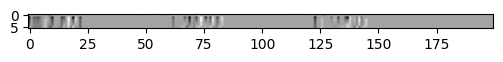

In [424]:
lc = LightCurve("plasticc_train_lightcurves.csv", "plasticc_train_metadata.csv", "high")
plt.figure(dpi=100)
zip_data, target = lc.compress_matrix_lightcurve(0, size=(6,200,1))
print(target)
plt.imshow(zip_data, cmap='gray')
zip_data.min(), zip_data.max()

In [8]:
lc = LightCurve("plasticc_train_lightcurves.csv", "plasticc_train_metadata.csv", "high")
lc.show_lightcurves_by_id(1, "all")

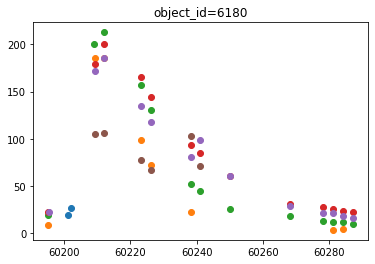

In [15]:
lc.show_lightcurves_by_id(31, "all")
plt.show()
#plt.figure(dpi=200)
#plt.imshow(data, cmap='gray')
#plt.title(f"target = {targets}")

Finding optimal frequency:
 - Estimated peak width = 0.00787
 - Using 5 steps per peak; omega_step = 0.00157
 - User-specified period range:  22 to 4e+02
 - Computing periods at 173 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/home/alex/.local/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/alex/.local/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/home/alex/.local/lib/python3.8/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  war

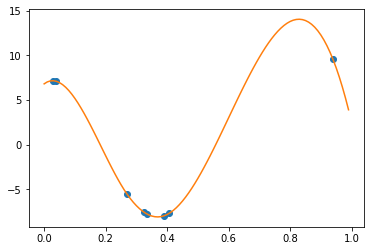

In [19]:
lc.show_phase_lightcurve(20, "i")

In [4]:
targets = pd.read_csv("../Data/plasticc_train_metadata.csv")

# preprocessing data

In [425]:
import torch

In [426]:
from sklearn.model_selection import train_test_split

In [427]:
lc = LightCurve("plasticc_train_lightcurves.csv", "plasticc_train_metadata.csv", "high")
length = lc.get_length()

In [428]:
data, targets = lc.load_all(length)

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116

number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)
number of targets = 2116 number of ids = 2116
print shape matrix = (6, 1200)


In [ ]:
data_phase, targets_phase = lc.load_all_phase(length)

In [429]:
X_train, X_test, y_train, y_test = train_test_split(
    data,
    targets[0], 
    test_size=0.4, 
    shuffle=True, random_state=3)

In [430]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.3, 
    shuffle=True, random_state=3)

In [556]:
lab = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
def plot_distributions(y_train, y_val, y_test, lab=lab):
    _train = [0]*len(lab)
    _val = [0]*len(lab)
    _test = [0]*len(lab)
    
    for i in range(len(lab)):
        _train[i] = y_train.tolist().count(i)
        _val[i] = y_val.tolist().count(i)
        _test[i] = y_test.tolist().count(i)
        
    labels = [f'{classes[lab[i]]}' for i in range(len(lab))]
    x = np.arange(len(labels))
    width = 0.75
    
    fig, ax = plt.subplots(dpi=150)
    fig.set_size_inches(13, 10)
    
    ax.bar(labels, _train, width, label='train', color="lightcoral")
    ax.bar(labels, _test, width, label='test', bottom=_train, color='lightblue')
    ax.bar(labels, _val, width, label='val', bottom=_train, color='mediumpurple')
    
    plt.xticks(x, labels, rotation='vertical')
    plt.legend()
    plt.show()

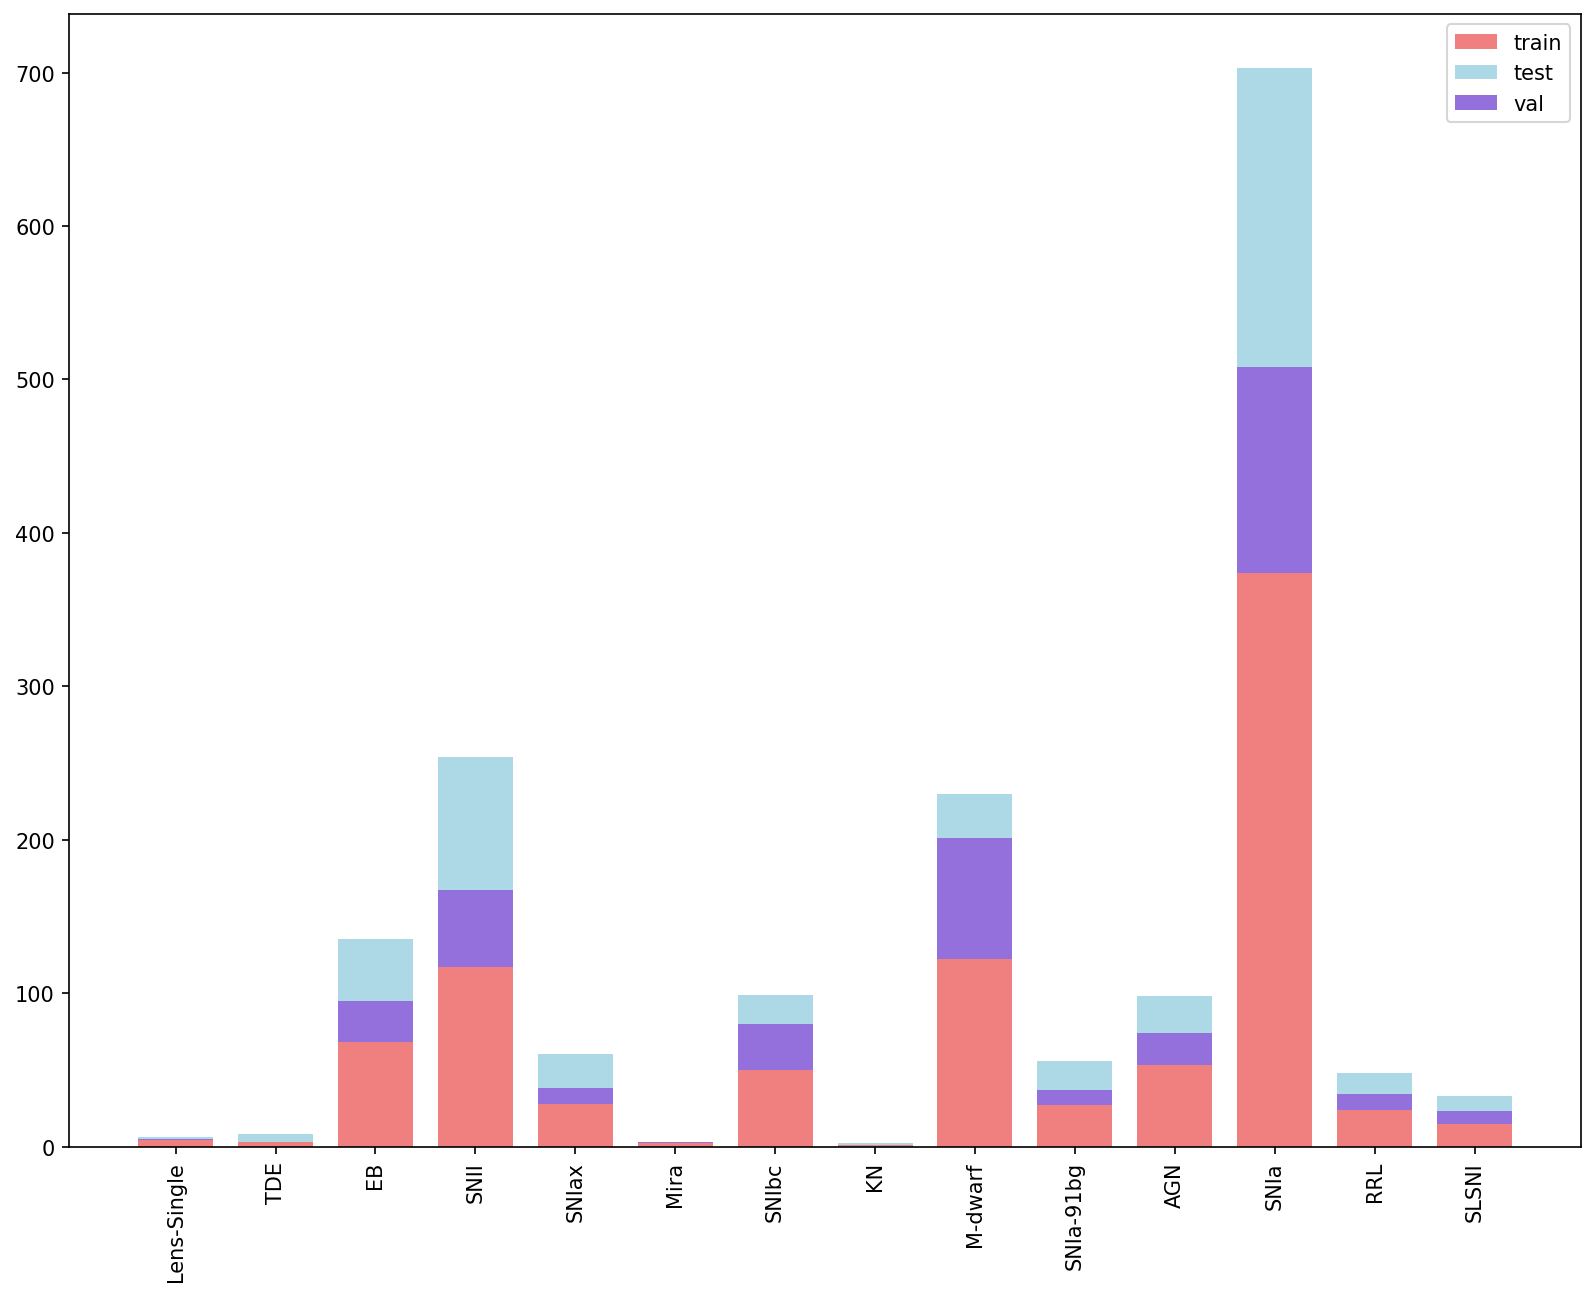

train size (888, 6, 200) validation size (381, 6, 200) test_size (847, 6, 200)


In [557]:
plot_distributions(y_train, y_val, y_test)
print(f"train size {X_train.shape} validation size {X_val.shape} test_size {X_test.shape}")

In [558]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
X_val = torch.FloatTensor(X_val)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
y_val = torch.LongTensor(y_val)

In [70]:
y_test

tensor([ 8,  8, 11,  8, 11,  2,  9,  3,  3, 10, 11, 11, 11, 11,  9,  6, 11, 11,
        11,  8, 11, 10,  3, 11,  2, 11, 11,  6, 13,  2, 11,  3,  3,  2, 11, 11,
        11, 10,  3, 11,  3,  4, 11,  8, 12, 11, 11,  9, 10,  8,  2, 11, 11,  2,
         2, 11, 12, 11,  6, 11, 11, 11,  3, 11,  8, 11,  8, 11,  8, 11, 11,  6,
        10, 11,  8,  2, 11, 11, 12, 11, 11, 11, 11, 11,  8,  6, 11, 11,  2, 11,
        11,  2,  6,  8,  3, 13,  4, 11,  3,  2, 11, 11, 11,  3, 11, 11,  4,  9,
        13, 12,  8,  2, 11,  6,  3,  8,  3,  2, 10, 11, 11, 11,  3, 11, 11,  2,
         8,  8, 11, 11,  3,  8,  8,  6,  3, 11, 11,  3,  3, 10, 11,  8,  2, 11,
        11, 11, 11, 11,  3,  8, 11, 12,  8, 10, 12, 11,  3,  8,  3,  3,  3,  8,
        11,  8,  2, 11, 11,  3, 11, 11,  8,  4, 11, 11,  3, 10,  2, 11, 11,  3,
         8, 11,  8,  3,  3, 11,  3, 11, 11, 11, 11, 11, 10, 11,  2,  6, 10, 13,
        11, 11, 11, 11,  8, 11,  8, 11,  6,  3,  3,  3, 11,  3, 10, 10,  3,  8,
         3,  8, 11,  1, 11, 11,  2,  9, 

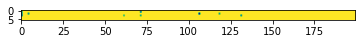

In [71]:
plt.imshow(X_train[6])

In [72]:
X_train.shape

torch.Size([888, 6, 200])

In [562]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()
X_val = X_val.unsqueeze(1).float()

In [74]:
X_train.shape

torch.Size([888, 1, 6, 200])

# Neural Net

In [563]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=1, kernel_size=(1,40), padding=0)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(1,2), stride=1)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=1, out_channels=1, kernel_size=(1,40), padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=(1,2), stride=1)
        
        self.fc1   = torch.nn.Linear(120*6*1, 130)
        self.act3  = torch.nn.Tanh()
        
        self.drop_layer = torch.nn.Dropout(p=0.6)
        
        self.fc2   = torch.nn.Linear(130, 80)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(80, 14)
        self.sm = torch.nn.Softmax(dim=1)
    
    def forward(self, x, show=False, drop=True):
        
        x = self.conv1(x)
        if show:
            print(f"size after first conv = {x.shape}")
        x = self.act1(x)
        #x = self.drop_layer(x)
        x = self.pool1(x)
        if show:
            print(f"size after first pool = {x.shape}")
        
        x = self.conv2(x)
        if show:
            print(f"size after second conv = {x.shape}")
        x = self.act2(x)
        x = self.pool2(x)
        if show:
            print(f"size after second pool = {x.shape}")
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        if show:
            print(x.shape)
        x = self.fc1(x)
        x = self.act3(x)
        #x = self.drop_layer(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
    def predict_proba(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    

In [564]:
net = ConvNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay=0.01)

In [565]:
batch_size = 128
num_epoch = 1000

train_accuracy_history = []
train_loss_history = []
val_accuracy_history = []
val_loss_history = []

X_val = X_val.to(device)
y_val = y_val.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)

for epoch in range(num_epoch):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = net.forward(X_val)
    val_loss_history.append(loss(test_preds, y_val).data.cpu())
    accuracy = (test_preds.argmax(dim=1) == y_val).float().mean().data.cpu()
    val_accuracy_history.append(accuracy)
    
    train_preds = net.forward(X_train)
    train_loss_history.append(loss(train_preds, y_train).data.cpu())
    train_accuracy = (train_preds.argmax(dim=1) == y_train).float().mean().data.cpu()
    train_accuracy_history.append(train_accuracy)
    
    print(f'current epoch {epoch}/{num_epoch} val loss = {loss(test_preds, y_val).data.cpu()}')

current epoch 0/1000 val loss = 2.2995753288269043
current epoch 1/1000 val loss = 1.8432799577713013
current epoch 2/1000 val loss = 1.7158617973327637
current epoch 3/1000 val loss = 1.6433433294296265
current epoch 4/1000 val loss = 1.6450680494308472
current epoch 5/1000 val loss = 1.6473487615585327
current epoch 6/1000 val loss = 1.6315804719924927
current epoch 7/1000 val loss = 1.6309623718261719
current epoch 8/1000 val loss = 1.6114706993103027
current epoch 9/1000 val loss = 1.592145323753357
current epoch 10/1000 val loss = 1.5638904571533203
current epoch 11/1000 val loss = 1.5214002132415771
current epoch 12/1000 val loss = 1.483940601348877
current epoch 13/1000 val loss = 1.4389886856079102
current epoch 14/1000 val loss = 1.3936421871185303
current epoch 15/1000 val loss = 1.4100254774093628
current epoch 16/1000 val loss = 1.3316255807876587
current epoch 17/1000 val loss = 1.3243552446365356
current epoch 18/1000 val loss = 1.3312599658966064
current epoch 19/1000 va

current epoch 159/1000 val loss = 1.0592224597930908
current epoch 160/1000 val loss = 1.0847115516662598
current epoch 161/1000 val loss = 1.0680296421051025
current epoch 162/1000 val loss = 1.0814309120178223
current epoch 163/1000 val loss = 1.108586311340332
current epoch 164/1000 val loss = 1.0645382404327393
current epoch 165/1000 val loss = 1.0770543813705444
current epoch 166/1000 val loss = 1.0757420063018799
current epoch 167/1000 val loss = 1.0666249990463257
current epoch 168/1000 val loss = 1.0630512237548828
current epoch 169/1000 val loss = 1.0854181051254272
current epoch 170/1000 val loss = 1.08920156955719
current epoch 171/1000 val loss = 1.126451849937439


KeyboardInterrupt: 

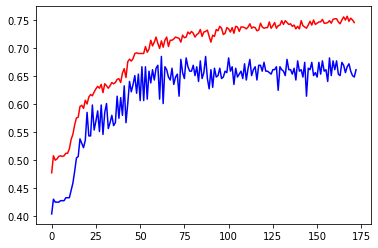

In [566]:
plt.plot(train_accuracy_history, 'r')
plt.plot(val_accuracy_history, 'b')

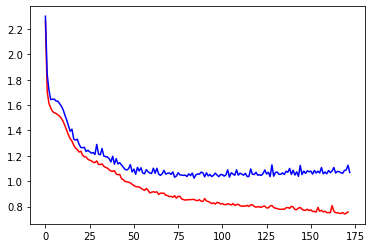

In [567]:
plt.plot(train_loss_history, 'r')
plt.plot(val_loss_history, 'b')

In [ ]:
preds = net.forward(X_test[122].unsqueeze(1)) 

In [ ]:
preds.argmax(dim=1)

In [ ]:
plt.imshow(X_test[57][0])

In [ ]:
plt.imshow(X_test[57][0])

In [ ]:
y_test[57]

# Confusion matrix

In [568]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    plt.figure(figsize=[10, 8], dpi=90)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();

In [569]:
preds = net.predict_proba(X_test).float().data
pred_lbl = np.argmax(preds, axis=1)
cm = confusion_matrix(y_test, pred_lbl)

Normalized confusion matrix


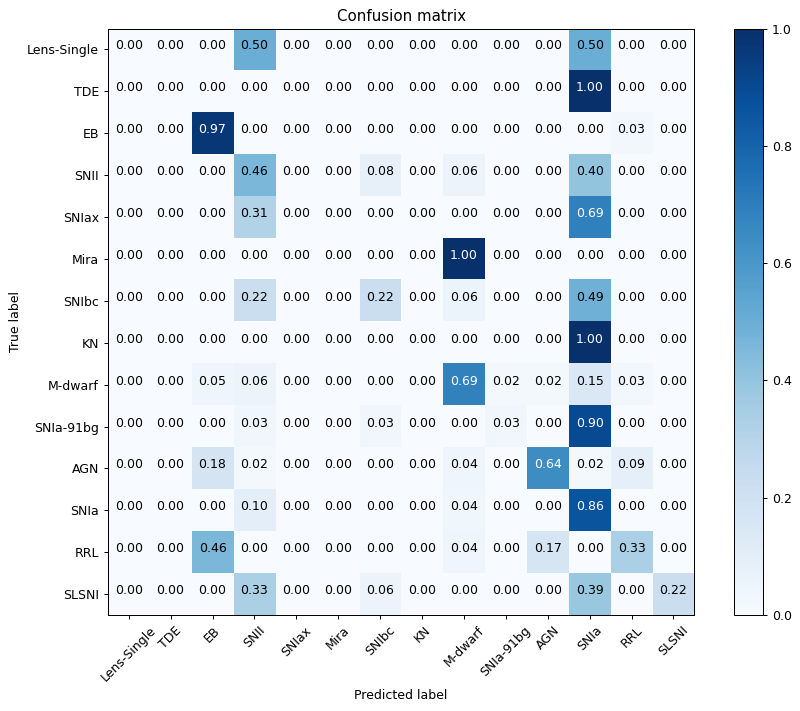

In [570]:
classes = {6:"Lens-Single", 15:"TDE", 16:"EB", 42:"SNII", 52:"SNIax", 53:"Mira", 62:"SNIbc", 64:"KN", 65:"M-dwarf", 67:"SNIa-91bg", 88:"AGN", 90:"SNIa", 92:"RRL", 95:"SLSNI"}
plot_confusion_matrix(cm, classes.values())

Normalized confusion matrix


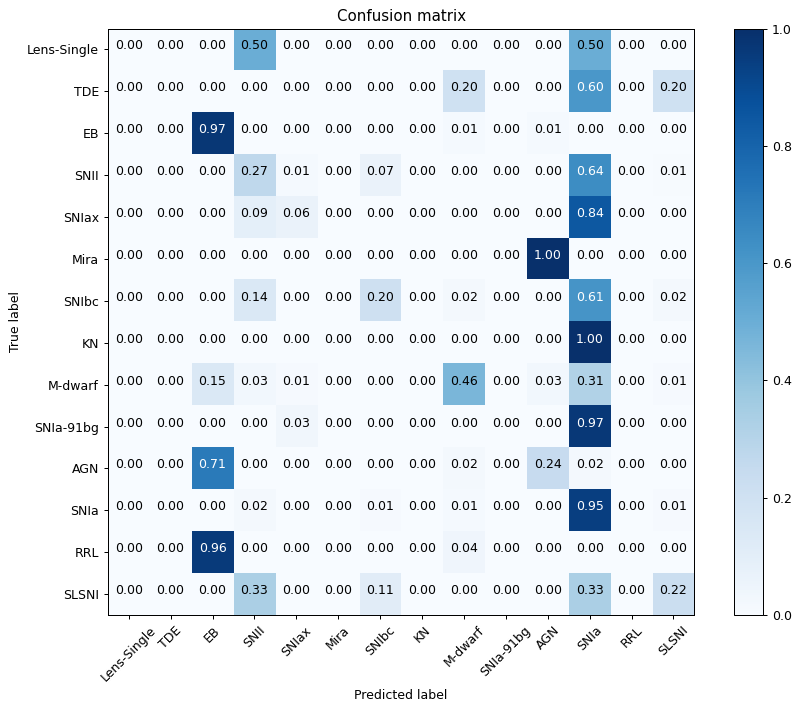

In [89]:
preds = net.predict_proba(X_test).float().data
pred_lbl = np.argmax(preds, axis=1)
cm = confusion_matrix(y_test, pred_lbl)
classes = {6:"Lens-Single", 15:"TDE", 16:"EB", 42:"SNII", 52:"SNIax", 53:"Mira", 62:"SNIbc", 64:"KN", 65:"M-dwarf", 67:"SNIa-91bg", 88:"AGN", 90:"SNIa", 92:"RRL", 95:"SLSNI"}
plot_confusion_matrix(cm, classes.values())

# Lomb-Scargle Periodogram to estimate the characteristic scale

In [ ]:
#!pip3 install gatspy
from gatspy.periodic import LombScargleMultibandFast

In [ ]:
data = pd.read_csv("../Data/plasticc_train_lightcurves.csv")

In [ ]:
obj_id = 70046
pb = 1
lc_mjd = data[data.object_id==obj_id][data.passband==pb].mjd.values
lc_flux = data[data['object_id']==obj_id][data.passband==pb].flux.values
lc_flux_err = data[data['object_id']==obj_id][data.passband==pb].flux_err.values
lc_passband = data[data['object_id']==obj_id][data.passband==pb].passband.values

In [ ]:
model = LombScargleMultibandFast(fit_period=True)
t_min = max(np.median(np.diff(sorted(lc_mjd))), 0.1)
t_max = min(1000., (lc_mjd.max() - lc_mjd.min())/2.)

model.optimizer.set(period_range=(t_min, t_max), first_pass_coverage=6)
model.fit(lc_mjd, lc_flux, dy=lc_flux_err, filts=lc_passband)
period = model.best_period

In [ ]:
phase = (lc_mjd /period) % 1

In [ ]:
plt.scatter(phase, lc_flux)

In [ ]:
plt.scatter(lc_mjd, lc_flux)

In [ ]:
from scipy import interpolate
def aproximation_func(x, *opt):
    n = len(opt)
    y = np.zeros((n, len(x)))
    for k in range(n):
        y[k] = opt[n-k-1]*x**k
    return np.sum(y, axis=0)

x = phase
y = lc_flux
params = np.polyfit(x, y, 5)
y = aproximation_func(x, *params)
print(y.shape)
f = interpolate.interp1d(x, y, kind='cubic', fill_value="extrapolate")

xnew = np.arange(0, 1, 0.01)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew)
plt.show()

In [21]:
targets

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.000,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.000,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.000,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.000,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.000,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0
5,1227,35.6836,-5.3794,1,0.000,0.000,0.000,-9.000,0.020,65,...,0.0,0.000,59570.000,47,2.3,11.6,31.6,240.0,632.4,1187.7
6,1598,347.8467,-64.7609,1,0.135,0.182,0.030,39.728,0.019,90,...,0.0,0.000,60628.816,20,0.0,0.0,0.0,0.0,0.0,0.0
7,1632,348.5959,-63.0726,1,0.686,0.701,0.010,43.152,0.021,42,...,3.1,0.051,59602.090,93,0.0,0.0,0.0,0.0,0.0,0.0
8,1920,149.4141,3.4338,1,0.309,0.323,0.336,41.140,0.027,90,...,0.0,0.000,59996.625,107,0.0,0.0,0.0,0.0,0.0,0.0
9,1926,149.4141,1.9401,1,0.000,0.000,0.000,-9.000,0.018,65,...,0.0,0.000,59570.000,15,16.6,130.6,450.4,2237.3,4903.2,8229.6


In [319]:
targets = pd.read_csv("../Data/plasticc_train_metadata.csv")
t_targets = [0]*2
t_targets[0] = targets[:1000]
t_targets[1] = targets[1000:]

In [374]:
unique[0]

array([92, 88, 42, 90, 65, 16, 67, 95, 62, 15, 52,  6, 64, 53])

In [320]:
unique = [0]*2
unique[0] = t_targets[0]['target'].unique()
unique[1] = t_targets[1]['target'].unique()
res = [0]*2
for i in range(2):
    res[i] = []
    for target in unique[i]:
        res[i].append([t_targets[i][t_targets[i]['target']==target]['target'].count(), target])
res = np.asarray(res)

In [321]:
unique_full = targets['target'].unique()
res_full = []
for target in unique_full:
    res_full.append([targets[targets['target']==target]['target'].count(), target])
res_full = np.asarray(res_full)

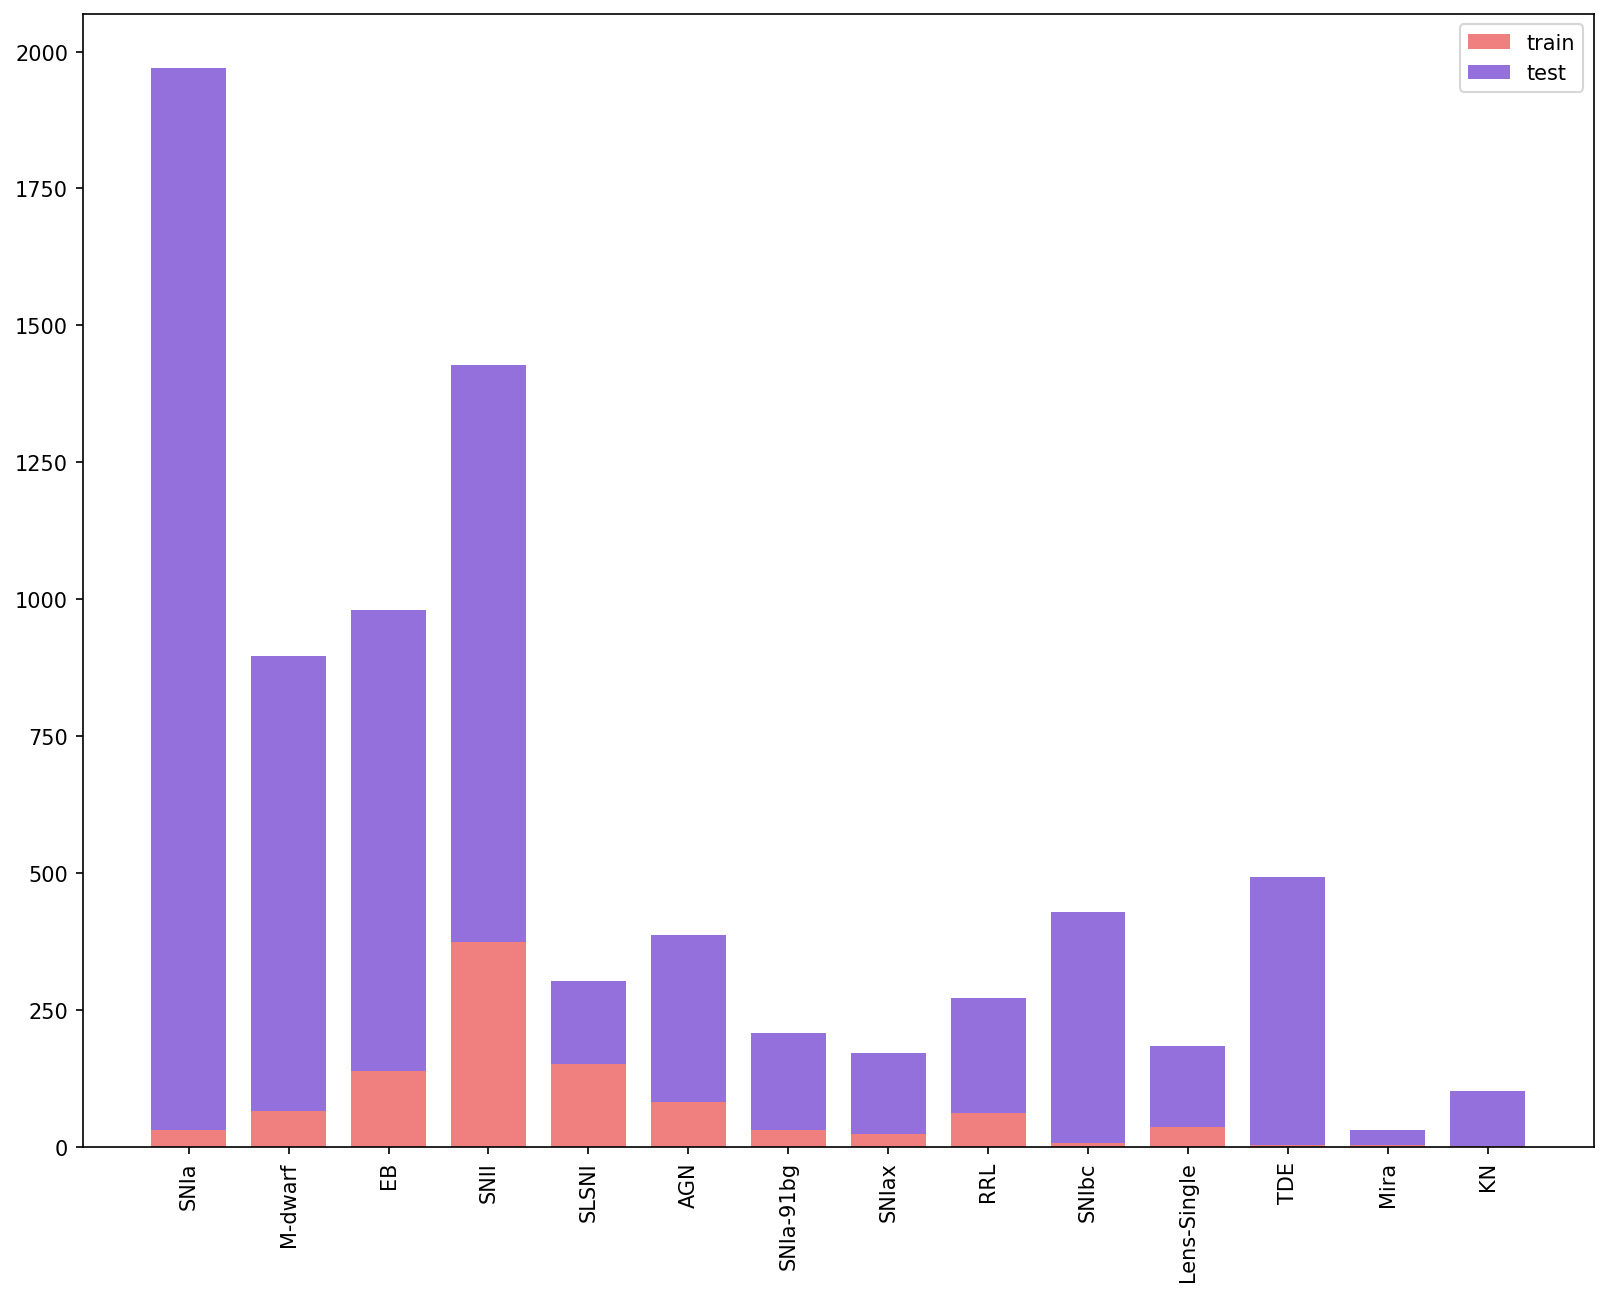

In [371]:
import matplotlib.pyplot as plt
import numpy as np

classes = {6:"Lens-Single", 15:"TDE", 16:"EB", 42:"SNII", 52:"SNIax", 53:"Mira", 62:"SNIbc", 64:"KN", 65:"M-dwarf", 67:"SNIa-91bg", 88:"AGN", 90:"SNIa", 92:"RRL", 95:"SLSNI"}
labels = [f'{classes[i]}' for i in res[1, :, 1]]
train = res[0, :, 0]
test = res[1, :, 0]

x = np.arange(len(labels))
width = 0.75


fig, ax = plt.subplots(dpi=150)
fig.set_size_inches(13, 10)
rects1 = ax.bar(labels, train, width, label='train', color="lightcoral")
rects2 = ax.bar(labels, test, width, label='test', bottom=train, color='mediumpurple')
plt.xticks(x, labels, rotation='vertical')
plt.legend()
plt.savefig("train_test.png", dpi=300)
plt.show()

In [372]:
y_train = [ 8,  8, 11,  8, 11,  2,  9,  3,  3, 10, 11, 11, 11, 11,  9,  6, 11, 11,
        11,  8, 11, 10,  3, 11,  2, 11, 11,  6, 13,  2, 11,  3,  3,  2, 11, 11,
        11, 10,  3, 11,  3,  4, 11,  8, 12, 11, 11,  9, 10,  8,  2, 11, 11,  2,
         2, 11, 12, 11,  6, 11, 11, 11,  3, 11,  8, 11,  8, 11,  8, 11, 11,  6,
        10, 11,  8,  2, 11, 11, 12, 11, 11, 11, 11, 11,  8,  6, 11, 11,  2, 11,
        11,  2,  6,  8,  3, 13,  4, 11,  3,  2, 11, 11, 11,  3, 11, 11,  4,  9,
        13, 12,  8,  2, 11,  6,  3,  8,  3,  2, 10, 11, 11, 11,  3, 11, 11,  2,
         8,  8, 11, 11,  3,  8,  8,  6,  3, 11, 11,  3,  3, 10, 11,  8,  2, 11,
        11, 11, 11, 11,  3,  8, 11, 12,  8, 10, 12, 11,  3,  8,  3,  3,  3,  8,
        11,  8,  2, 11, 11,  3, 11, 11,  8,  4, 11, 11,  3, 10,  2, 11, 11,  3,
         8, 11,  8,  3,  3, 11,  3, 11, 11, 11, 11, 11, 10, 11,  2,  6, 10, 13,
        11, 11, 11, 11,  8, 11,  8, 11,  6,  3,  3,  3, 11,  3, 10, 10,  3,  8,
         3,  8, 11,  1, 11, 11,  2,  9,  3, 11,  8, 11, 10, 11,  8, 11,  3, 11,
        11, 11, 11,  9, 12,  9,  2,  2, 11,  6, 10,  2, 11, 11,  8,  8,  1,  8,
        12, 11,  8,  2, 11, 11, 11, 11,  2,  3, 11, 10,  3, 11,  3,  6,  8,  3,
        12, 13,  6, 11,  6,  8, 12,  4,  3,  9, 11,  9,  8, 11,  6,  3, 11,  8,
        11, 11, 12,  2,  6, 10, 10,  6,  3, 11, 11, 11, 11,  6,  3,  9,  3, 11,
         3, 10,  3,  8,  2, 11, 10, 11,  8, 12, 10,  2, 11, 10, 13, 11,  4,  3,
         3,  8,  9, 11,  5, 10,  8,  4, 11,  3, 11, 11, 11, 11,  6, 11,  4, 11,
         2,  8,  1,  9, 13, 10, 11,  8,  6,  3,  3, 11,  3, 11, 11, 11, 11,  8,
        11, 12,  8,  2,  4,  8, 11,  2,  4,  3,  3,  4, 11,  8,  3, 11,  3,  2,
         3,  3, 11,  4, 11,  2, 11, 11,  2,  3,  8, 10, 11, 11,  6,  6, 11, 11,
         6, 11, 11,  4, 11, 11,  2, 11,  6, 10,  2,  4,  2, 11,  4,  6,  2,  3,
         2,  4,  8,  8, 12, 11, 11, 11, 11, 11,  6,  8,  8, 11,  3, 11,  3,  6,
         2,  8, 11,  3, 11, 11, 11, 11,  3, 11,  8,  3, 11, 10,  9,  4,  3, 11,
         8,  2, 11, 12, 11,  6, 11, 11, 11, 11,  2,  4, 11,  3,  6, 11,  3,  3,
         0, 12,  6, 11, 11, 11, 11,  2,  8, 13,  3, 11,  3, 11,  2, 11,  8, 11,
         4, 11, 10, 10, 11,  8,  3,  4,  8, 11, 10,  4,  6,  2,  8, 11, 11, 11,
        11, 11,  6, 11,  9, 11,  8,  8,  3,  8,  2, 11,  9, 11,  6,  2,  6, 11,
         3, 11,  8, 11,  1,  3,  8,  3,  4, 11, 13,  3, 11,  8,  3,  3, 11, 11,
        13,  8, 10,  4,  6, 11,  2, 13,  8, 11, 11, 11, 11, 11,  6,  8,  6,  9,
         8, 11, 11, 13,  8, 11, 10, 13,  6,  4,  8, 11,  2, 11,  3,  6,  2, 11,
        11, 12, 11,  9, 11, 13,  8, 11,  8,  3, 11, 11,  9, 11, 11,  4,  6, 11,
         3, 11, 12,  8, 11,  3, 11, 11,  3, 11,  8, 11,  3, 11,  2,  3, 11, 11,
        11, 11,  8, 11, 11, 11, 11,  8, 10,  3,  6,  3, 11,  2,  3, 11, 12,  3,
        11,  8, 11,  3,  3,  0, 12, 11, 11, 11,  2,  3, 11, 11, 11,  6,  3, 11,
         9,  8,  6, 11, 11,  6,  3, 11, 11, 11, 11,  4,  3,  3, 10,  3, 11,  2,
        11, 11, 11,  3, 11,  2,  3,  8, 11,  8, 11,  3, 10, 10,  9, 11,  3,  8,
         3,  6,  3,  3, 11,  2,  3, 11, 11, 11,  3,  3,  3,  7,  3, 11, 11, 11,
        11,  9, 11, 11,  3,  8,  3, 10,  3, 11,  3, 11, 11, 11,  8, 11,  8, 11,
         9,  2,  3, 11, 13,  2,  3,  2, 11,  8,  3,  3, 11,  6, 10, 11, 11,  9,
        11, 13,  3, 10,  8, 11, 12, 11, 11,  9,  3,  3, 11, 11, 10, 11,  8, 11,
         8,  1,  9,  6, 11,  3,  3,  9, 11,  4, 10,  9, 11, 11, 11, 10,  4,  3,
         4, 11,  8, 13,  3,  9, 11, 11, 12, 11, 11, 13, 11, 12, 11, 11,  2,  8,
        11, 11,  8,  6,  2, 11,  4, 11,  8,  8,  3,  4,  2, 11,  3,  3, 12,  8,
         8, 11,  8,  3,  2, 11,  3,  6, 10,  3, 10,  8, 11,  8,  9, 10, 11,  2,
         8,  2,  4,  2, 11,  8, 11,  3,  8, 11,  2,  8,  3,  3, 11,  2, 11, 11,
         3]

In [377]:
y_train

False

In [554]:
lab = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
def plot_distributions(y_train, y_val, y_test, lab=lab):
    _train = [0]*len(lab)
    _val = [0]*len(lab)
    _test = [0]*len(lab)
    
    for i in range(len(lab)):
        _train[i] = y_train.tolist().count(i)
        _val[i] = y_val.tolist().count(i)
        _test[i] = y_test.tolist().count(i)
        
    labels = [f'{classes[lab[i]]}' for i in range(len(lab))]
    x = np.arange(len(labels))
    width = 0.75
    
    fig, ax = plt.subplots(dpi=150)
    fig.set_size_inches(13, 10)
    
    ax.bar(labels, _train, width, label='train', color="lightcoral")
    ax.bar(labels, _test, width, label='test', bottom=_train, color='lightblue')
    ax.bar(labels, _val, width, label='val', bottom=_train, color='mediumpurple')
    
    plt.xticks(x, labels, rotation='vertical')
    plt.legend()
    plt.show()

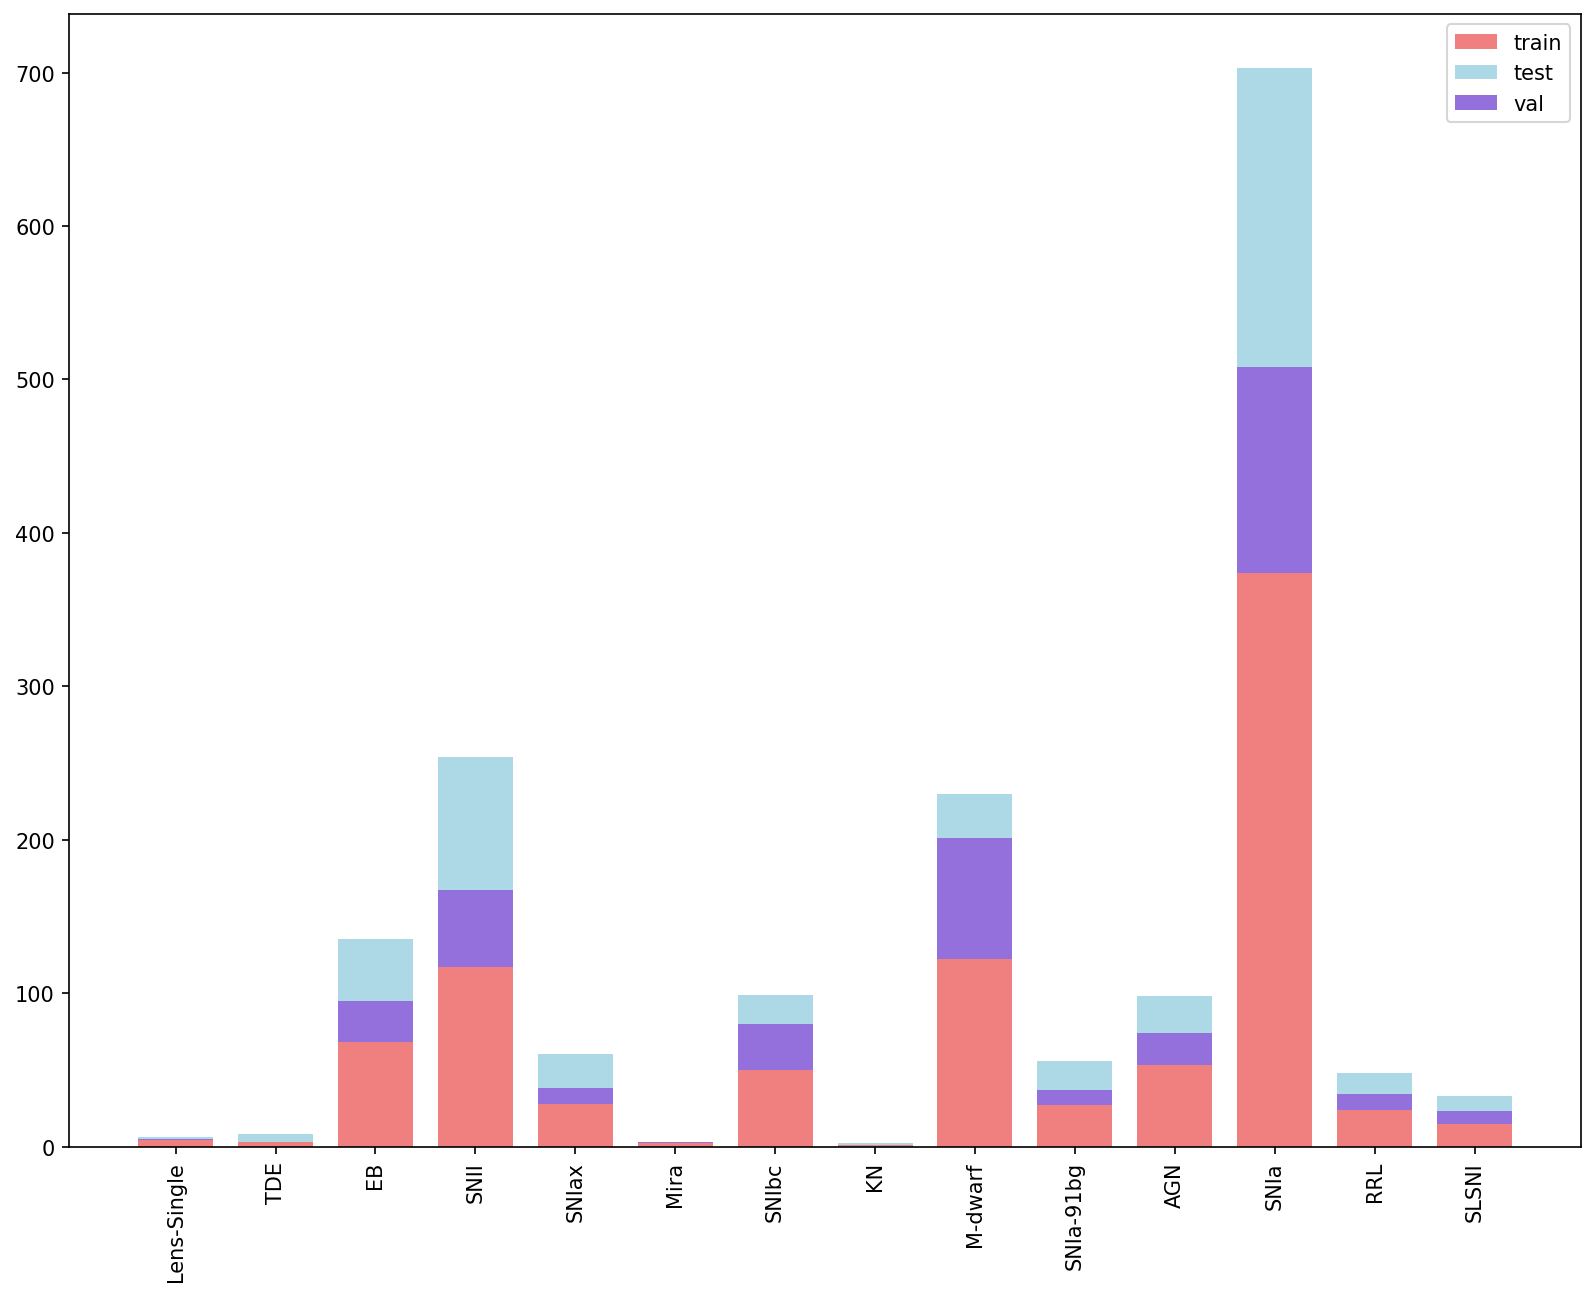

In [555]:
plot_distributions(y_train, y_val, y_test)